# Data loading

In [1]:
import sqlite3
import numpy as np
import pandas as pd
conn = sqlite3.connect('meta_final.db')  
df = pd.read_sql_query('SELECT * FROM classificationreport', conn)
df.head()

,id,dataset,task,embedder,model,hyperparams,library_hash,cv_metric_name,cv_metric,test_metric_name,test_metric,key
0,1,AMES,classification,CDDD,rf,"{""clf__criterion"": ""entropy"", ""clf__min_sample...",-4078789695080322729,roc_auc,0.827767,roc_auc,0.832276,AMES_CDDD_rf
1,2,AMES,classification,CDDD,ridge,"{""clf__C"": 0.0035938136638046254, ""clf__max_it...",-4078789695080322729,roc_auc,0.812764,roc_auc,0.819405,AMES_CDDD_ridge
2,3,AMES,classification,CDDD,knn,"{""clf__n_neighbors"": 9}",-4078789695080322729,roc_auc,0.801416,roc_auc,0.835524,AMES_CDDD_knn
3,4,Bioavailability_Ma,classification,AtomPair,rf,"{""clf__criterion"": ""entropy"", ""clf__min_sample...",-1464569385253146410,roc_auc,0.703187,roc_auc,0.695710,Bioavailability_Ma_AtomPair_rf
4,5,Bioavailability_Ma,classification,TT,rf,"{""clf__criterion"": ""entropy"", ""clf__min_sample...",-439122730216982411,roc_auc,0.750404,roc_auc,0.691553,Bioavailability_Ma_TT_rf


In [2]:
df.to_csv('classificationreport.csv', index=False)

In [3]:
df['embedder'].nunique()

57

In [4]:
df['dataset'].nunique()

25

In [5]:
df['dataset'].unique()

array(['AMES', 'Bioavailability_Ma', 'CYP1A2_Veith', 'CYP2C19_Veith',
       'CYP2C9_Substrate_CarbonMangels', 'CYP2D6_Substrate_CarbonMangels',
       'CYP3A4_Substrate_CarbonMangels', 'CYP2C9_Veith', 'DILI',
       'HIA_Hou', 'PAMPA_NCATS', 'Pgp_Broccatelli', 'CYP2D6_Veith',
       'CYP3A4_Veith', 'SARSCoV2_3CLPro_Diamond', 'SARSCoV2_Vitro_Touret',
       'hERG', 'ogbg-molbace', 'ogbg-molbbbp', 'hERG_Karim',
       'ogbg-molhiv', 'ogbg-molclintox', 'ogbg-molsider', 'ogbg-moltox21',
       'ogbg-molmuv'], dtype=object)

In [6]:
df.groupby('embedder')['dataset'].size().sort_values(ascending=True)

embedder
AtomPair                   73
GraphMVP_CP-max            73
GraphMVP_CP-mean           73
GraphMVP_CP-sum            73
MoLFormer-XL-both-10pct    73
SELFormer                  73
SELFormer-Lite             73
SimSon                     73
TT                         73
TT_count                   73
chemformer_augment         73
chemformer_combined        73
chemformer_mask            73
coati                      73
grover_base                73
grover_large               73
mat_masking_200k           73
mat_masking_20M            73
mat_masking_2M             73
mol2vec                    73
mol_r_gat_1024             73
mol_r_gcn_1024             73
mol_r_sage_1024            73
mol_r_tag_1024             73
molbert                    73
rmat_4M                    73
GraphMVP_AM-sum            73
unimolv1                   73
GraphMVP_AM-mean           73
GraphFP-CP                 73
AtomPair_count             73
CDDD                       73
CLAMP                      73
C

In [7]:
df.groupby('dataset')['embedder'].nunique().sort_values(ascending=True)

dataset
AMES                              57
ogbg-molmuv                       57
ogbg-molhiv                       57
ogbg-molclintox                   57
ogbg-molbbbp                      57
ogbg-molbace                      57
hERG_Karim                        57
hERG                              57
SARSCoV2_Vitro_Touret             57
SARSCoV2_3CLPro_Diamond           57
Pgp_Broccatelli                   57
ogbg-molsider                     57
PAMPA_NCATS                       57
DILI                              57
CYP3A4_Veith                      57
CYP3A4_Substrate_CarbonMangels    57
CYP2D6_Veith                      57
CYP2D6_Substrate_CarbonMangels    57
CYP2C9_Veith                      57
CYP2C9_Substrate_CarbonMangels    57
CYP2C19_Veith                     57
CYP1A2_Veith                      57
Bioavailability_Ma                57
HIA_Hou                           57
ogbg-moltox21                     57
Name: embedder, dtype: int64

## Selecting best variant for each of the models

In [8]:
df2 = df.groupby(['embedder', 'dataset'])['test_metric'].max().reset_index()
df2.head()

,embedder,dataset,test_metric
0,AtomPair,AMES,0.808812
1,AtomPair,Bioavailability_Ma,0.695710
2,AtomPair,CYP1A2_Veith,0.924159
3,AtomPair,CYP2C19_Veith,0.846214
4,AtomPair,CYP2C9_Substrate_CarbonMangels,0.582746


In [9]:
ecfp_perf = df2[df2['embedder'] == 'ECFP_count'][['test_metric', 'dataset']].rename(columns={'test_metric': 'ecfp'})
df22 = df2.merge(
    ecfp_perf,
    on='dataset',
)
overperf_datasets = df22[df22['ecfp'] < df22['test_metric']].groupby('dataset').size() / len(df22['embedder'].unique())
overperf_models = df22[df22['ecfp'] < df22['test_metric']].groupby('embedder').size() / len(df22['dataset'].unique())

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [11]:
sns.set_style(style="whitegrid")

In [12]:
# rank_data = df[df['embedder'].isin(models_to_use) & (~df['dataset'].isin(['ogbg-molhiv', 'ClinTox']))]
rank_data = df.copy()
rank_data['n_metric'] = rank_data['test_metric']
# rank_data['n_metric'] = rank_data['normalized_metric'].round(2)
rank_data['rank'] = rank_data.groupby(['dataset', 'model'])['n_metric'].rank(ascending=False, method='average')
perf = rank_data.groupby(['embedder', 'model'])['rank'].mean().reset_index().pivot(index='embedder', columns='model', values='rank')

best_rank = rank_data.groupby(['dataset', 'embedder'])['n_metric'].max().reset_index()
best_rank['best'] = best_rank.groupby('dataset')['n_metric'].rank(ascending=False, method='average')

perf = perf.merge(best_rank.groupby('embedder')['best'].mean(), left_index=True, right_index=True).sort_values(by='best', ascending=True)
perf.round(2).reset_index()

,embedder,knn,rf,ridge,best
0,CLAMP,8.78,9.08,9.58,8.84
1,rmat_4M,9.70,8.78,8.44,8.96
2,molbert,10.70,8.94,10.84,11.04
3,ChemBERTa-10M-MTR,10.17,12.04,14.36,11.64
4,ECFP_count,27.04,9.86,17.80,11.78
5,CDDD,11.17,11.16,16.28,12.42
6,mat_masking_2M,14.43,13.80,12.62,12.70
7,AtomPair_count,14.04,13.68,18.12,13.42
8,ChemBERTa-77M-MTR,12.04,13.92,15.28,13.86
9,ChemBERTa-5M-MTR,10.91,13.88,18.60,14.38


In [13]:
model_mapping = {
    'mol2vec': 'Mol2Vec',
    'coati': 'COATI',
    'CDDD': 'CDDD',
    'AtomPair': 'AtomPair',
    'AtomPair_count': 'AtomPair',
    'ECFP_count': 'ECFP',
    'ECFP': 'ECFP',
    'TT': 'TT',
    'TT_count': 'TT',
    'GraphMVP_CP-max': 'GraphMVP',
    'GraphMVP_CP-sum': 'GraphMVP',
    'GraphMVP_CP-mean': 'GraphMVP',
    'GraphMVP_AM-max': 'GraphMVP',
    'GraphMVP_AM-sum': 'GraphMVP',
    'GraphMVP_AM-mean': 'GraphMVP',
    'ChemBERTa-10M-MTR': 'ChemBERTa',
    'ChemBERTa-5M-MTR': 'ChemBERTa',
    'ChemBERTa-10M-MLM': 'ChemBERTa',
    'ChemBERTa-5M-MLM': 'ChemBERTa',
    'ChemBERTa-77M-MTR': 'ChemBERTa',
    'ChemBERTa-77M-MLM': 'ChemBERTa',
    'ChemFM-1B': 'ChemFM',
    'ChemFM-3B': 'ChemFM',
    'ChemGPT-4.7M': 'ChemGPT',
    'ChemGPT-19M': 'ChemGPT',
    'MoLFormer-XL-both-10pct': 'MoLFormer',
    'mol_r_tag_1024': 'MolR',
    'mol_r_sage_1024': 'MolR',
    'mol_r_gcn_1024': 'MolR',
    'mol_r_gat_1024': 'MolR',
    'chemformer_augment': 'ChemFormer',
    'chemformer_mask': 'ChemFormer',
    'chemformer_combined': 'ChemFormer',
    'SimSon': 'SimSon',
    'MolTransformer': 'MolTransformer',
    'CLAMP': 'CLAMP',
    'mat_masking_20M': 'MAT',
    'mat_masking_2M': 'MAT',
    'mat_masking_200k': 'MAT',
    'grover_base': 'Grover',
    'grover_large': 'Grover',
    'rmat_4M': 'RMAT',
    'GraphFP-C': 'GraphFP',
    'GraphFP-CP': 'GraphFP',
    'molbert': 'MolBERT',
    'GEM': 'GEM',
    'GNN-EP-sum': 'GIN',
    'GNN-Contextual-sum': 'GIN',
    'GNN-GPT_TNN-sum': 'GIN',
    'GNN-CP-sum': 'GIN',
    'GNN-GraphCL-sum': 'GIN',
    'GNN-IG-sum': 'GIN',
    'GNN-Motif-sum': 'GIN',
    'GNN-AM-sum': 'GIN',
    'unimolv1': 'UniMolv1',
    'unimolv2': 'UniMolv2',
    'SELFormer': 'SELFormer',
    'SELFormer-Lite': 'SELFormer',
}

In [14]:
mean_auroc = df.groupby(['embedder', 'dataset']).max().reset_index().groupby('embedder')['test_metric'].mean().reset_index()
mean_auroc['family'] = mean_auroc['embedder'].map(model_mapping)
mean_auroc['best_within'] = mean_auroc.groupby('family')['test_metric'].transform('max')
mean_auroc = mean_auroc[mean_auroc['test_metric'] == mean_auroc['best_within']]
candidate_models = mean_auroc['embedder'].unique().tolist()
candidate_models

['AtomPair_count',
 'CDDD',
 'CLAMP',
 'ChemBERTa-10M-MTR',
 'ChemFM-3B',
 'ChemGPT-4.7M',
 'ECFP_count',
 'GEM',
 'GNN-GraphCL-sum',
 'GraphFP-CP',
 'GraphMVP_CP-max',
 'MoLFormer-XL-both-10pct',
 'SELFormer-Lite',
 'SimSon',
 'TT',
 'chemformer_mask',
 'coati',
 'grover_large',
 'mat_masking_2M',
 'mol2vec',
 'mol_r_tag_1024',
 'molbert',
 'rmat_4M',
 'unimolv1',
 'unimolv2']

In [15]:
# rank_data = df[df['embedder'].isin(models_to_use) & (~df['dataset'].isin(['ogbg-molhiv', 'ClinTox']))]
rank_data = df.copy()
# rank_data['n_metric'] = rank_data['normalized_metric'].round(2)

best = rank_data.groupby(['dataset', 'embedder'])['test_metric'].max().reset_index()
best['model'] = 'best'

rank_data = pd.concat([
    rank_data,
    best,
])

rank_data['rank'] = rank_data.groupby(['dataset', 'model'])['test_metric'].rank(ascending=False, method='average')
perf = rank_data.groupby(['embedder', 'model'])[['rank', 'test_metric']].mean().reset_index().melt(id_vars=['embedder', 'model'], var_name='metric', value_name='value').pivot(
    index='embedder', columns=['metric', 'model'], values='value'
)

# Round all 'rank' columns to 2 decimal places
perf.loc[:, perf.columns.get_level_values(0) == 'rank'] = perf.loc[:, perf.columns.get_level_values(0) == 'rank'].applymap(lambda x: round(x, 2))

# Format all 'test_metric' columns as percentages with 2 decimals
perf.loc[:, perf.columns.get_level_values(0) == 'test_metric'] = perf.loc[:, perf.columns.get_level_values(0) == 'test_metric'].applymap(lambda x: f"{x:.2%}")

perf = perf.sort_values(by=('rank', 'best'), ascending=True).reset_index()

perf

metric                 embedder   rank                      test_metric  \
model                             best    knn     rf  ridge        best   
0                         CLAMP   8.84   8.78   9.08   9.58      82.55%   
1                       rmat_4M   8.96   9.70   8.78   8.44      80.83%   
2                       molbert  11.04  10.70   8.94  10.84      80.51%   
3             ChemBERTa-10M-MTR  11.64  10.17  12.04  14.36      79.99%   
4                    ECFP_count  11.78  27.04   9.86  17.80      79.89%   
5                          CDDD  12.42  11.17  11.16  16.28      80.60%   
6                mat_masking_2M  12.70  14.43  13.80  12.62      80.18%   
7                AtomPair_count  13.42  14.04  13.68  18.12      79.48%   
8             ChemBERTa-77M-MTR  13.86  12.04  13.92  15.28      79.48%   
9              ChemBERTa-5M-MTR  14.38  10.91  13.88  18.60      79.64%   
10              mat_masking_20M  15.00  14.30  16.52  12.44      79.67%   
11      MoLFormer-XL-both-10pct  15.42  11.48  15.96  21.28      79.80%   
12                      mol2vec  16.92  18.22  16.52  17.28      79.55%   
13                         ECFP  17.82  25.96  16.00  18.74      78.94%   
14                     AtomPair  18.44  16.65  16.32  18.44      78.60%   
15             mat_masking_200k  18.64  23.26  21.26  12.72      79.10%   
16                     TT_count  20.32  31.78  19.28  25.00      78.08%   
17                           TT  21.04  25.48  18.88  22.80      78.12%   
18                    ChemFM-3B  22.48  27.70  33.92  15.36      78.25%   
19                     unimolv2  23.76  29.61  27.92  19.40      78.11%   
20               mol_r_tag_1024  24.20  22.61  23.22  22.04      77.84%   
21                        coati  24.62  23.30  24.00  23.40      78.02%   
22              chemformer_mask  25.68  23.43  26.92  22.28      77.44%   
23              GraphMVP_CP-max  26.64  18.35  23.72  35.32      77.18%   
24              GraphMVP_AM-max  27.40  28.78  23.20  33.94      77.13%   
25            ChemBERTa-10M-MLM  28.28  31.61  26.68  29.48      76.46%   
26          chemformer_combined  29.04  28.39  34.40  23.60      76.86%   
27               mol_r_gat_1024  29.16  29.13  28.38  28.20      76.72%   
28              mol_r_sage_1024  29.48  30.91  30.12  27.60      77.04%   
29               mol_r_gcn_1024  30.84  28.39  28.74  28.52      76.59%   
30                    ChemFM-1B  30.96  37.76  39.12  23.64      76.07%   
31                     unimolv1  31.04  25.65  28.20  26.08      76.85%   
32              GraphMVP_CP-sum  32.74  26.78  32.92  33.56      75.58%   
33              GNN-GraphCL-sum  33.00  30.83  29.40  35.24      75.14%   
34              GraphMVP_AM-sum  33.68  27.28  32.44  35.26      75.29%   
35                 grover_large  34.16  43.30  38.78  30.90      75.68%   
36           chemformer_augment  35.32  40.09  38.68  32.72      75.32%   
37                  grover_base  35.72  41.17  37.32  33.64      75.21%   
38             GraphMVP_CP-mean  36.32  31.00  36.48  37.40      74.76%   
39             GraphMVP_AM-mean  36.50  30.26  35.48  40.12      74.17%   
40           GNN-Contextual-sum  36.60  34.35  34.98  37.56      74.47%   
41             ChemBERTa-5M-MLM  37.88  37.83  34.66  36.16      74.20%   
42                  ChemGPT-19M  38.38  33.61  37.78  38.36      73.77%   
43            ChemBERTa-77M-MLM  39.00  40.20  39.14  36.40      72.92%   
44                 ChemGPT-4.7M  39.40  35.13  36.84  40.72      74.01%   
45                       SimSon  39.52  33.26  40.16  43.66      73.56%   
46                          GEM  39.72  31.57  38.52  39.96      74.03%   
47                   GNN-IG-sum  41.00  35.02  38.00  43.84      73.08%   
48               SELFormer-Lite  41.04  38.04  41.92  39.56      73.18%   
49                GNN-Motif-sum  41.28  38.70  38.72  43.42      73.21%   
50                   GNN-CP-sum  44.00  47.17  45.00  40.48      72.08%   
51                    SEL

## Best model rank + AUROC table

In [16]:
# rank_data = df[df['embedder'].isin(models_to_use) & (~df['dataset'].isin(['ogbg-molhiv', 'ClinTox']))]
rank_data = df[df['embedder'].isin(candidate_models)].copy()
# rank_data['n_metric'] = rank_data['normalized_metric'].round(2)

best = rank_data.groupby(['dataset', 'embedder'])['test_metric'].max().reset_index()
best['model'] = 'best'

rank_data = pd.concat([
    rank_data,
    best,
])

rank_data['rank'] = rank_data.groupby(['dataset', 'model'])['test_metric'].rank(ascending=False, method='average')
perf = rank_data.groupby(['embedder', 'model'])[['rank', 'test_metric']].mean().reset_index().melt(id_vars=['embedder', 'model'], var_name='metric', value_name='value').pivot(
    index='embedder', columns=['metric', 'model'], values='value'
)

# Round all 'rank' columns to 2 decimal places
perf.loc[:, perf.columns.get_level_values(0) == 'rank'] = perf.loc[:, perf.columns.get_level_values(0) == 'rank'].applymap(lambda x: round(x, 2))

# Format all 'test_metric' columns as percentages with 2 decimals
perf.loc[:, perf.columns.get_level_values(0) == 'test_metric'] = perf.loc[:, perf.columns.get_level_values(0) == 'test_metric'].applymap(lambda x: f"{x:.2%}")

perf = perf.sort_values(by=('rank', 'best'), ascending=True).reset_index()

perf[[('embedder', ''), ('rank', 'best'), ('test_metric', 'best')]]

metric,embedder,rank,test_metric
model,,best,best
0,CLAMP,5.40,82.55%
1,rmat_4M,6.08,80.83%
2,molbert,6.92,80.51%
3,ChemBERTa-10M-MTR,7.32,79.99%
4,ECFP_count,7.52,79.89%
5,CDDD,7.64,80.60%
6,AtomPair_count,7.88,79.48%
7,mat_masking_2M,8.02,80.18%
8,MoLFormer-XL-both-10pct,9.50,79.80%


In [17]:
names = {
    'AtomPair_count': 'Atom Pair',
    'CDDD': 'CDDD',
    'CLAMP': 'CLAMP',
    'ChemBERTa-10M-MTR': 'ChemBERTa',
    'ChemFM-3B': 'ChemFM',
    'ECFP_count': 'ECFP',
    'GEM': 'GEM',
    'GNN-GraphCL-sum': 'GIN',
    'GraphFP-CP': 'GraphFP',
    'GraphMVP_CP-max': 'GraphMVP',
    'MoLFormer-XL-both-10pct': 'MoLFormer',
    'SELFormer-Lite': 'SELFormer',
    'SimSon': 'SimSon',
    'TT': 'TT',
    'chemformer_mask': 'Chemformer',
    'coati': 'COATI',
    'grover_large': 'GROVER',
    'mat_masking_2M': 'MAT',
    'mol2vec': 'Mol2Vec',
    'mol_r_tag_1024': 'MolR',
    'molbert': 'MolBERT',
    'rmat_4M': 'R-MAT',
    'unimolv1': 'Uni-Mol',
    'unimolv2': 'Uni-Mol2',
    'ChemGPT-4.7M': 'ChemGPT',
}

set(candidate_models) - set(names.keys())

set()

In [18]:
z = perf[[('embedder', ''), ('rank', 'best'), ('test_metric', 'best')]]
z.columns = ['Model', 'Mean rank', 'Mean ROCAUC']
z['Model'] = z['Model'].map(names)
# z['Rank'] = z.index + 1
z = z[['Model', 'Mean rank', 'Mean ROCAUC']]
z.to_latex('ranks.tex', index=False)

/var/folders/hs/250xkhr95fg75n5m5v0nr64c0000gn/T/ipykernel_24523/31710454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z['Model'] = z['Model'].map(names)
/var/folders/hs/250xkhr95fg75n5m5v0nr64c0000gn/T/ipykernel_24523/31710454.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  z.to_latex('ranks.tex', index=False)


In [19]:
df3 = df2[df2['embedder'].isin(candidate_models)].copy()
df3.head()

,embedder,dataset,test_metric
25,AtomPair_count,AMES,0.814525
26,AtomPair_count,Bioavailability_Ma,0.712005
27,AtomPair_count,CYP1A2_Veith,0.928864
28,AtomPair_count,CYP2C19_Veith,0.858162
29,AtomPair_count,CYP2C9_Substrate_CarbonMangels,0.596310


In [20]:
order_new = z['Model'].tolist()

In [21]:
order_new

['CLAMP',
 'R-MAT',
 'MolBERT',
 'ChemBERTa',
 'ECFP',
 'CDDD',
 'Atom Pair',
 'MAT',
 'MoLFormer',
 'Mol2Vec',
 'TT',
 'ChemFM',
 'Uni-Mol2',
 'MolR',
 'COATI',
 'GraphMVP',
 'Chemformer',
 'Uni-Mol',
 'GROVER',
 'GIN',
 'SimSon',
 'ChemGPT',
 'GEM',
 'SELFormer',
 'GraphFP']

## Per dataset performance of the models

In [22]:
df4 = df3.merge(
    ecfp_perf,
    on='dataset',
)
df4.head()

,embedder,dataset,test_metric,ecfp
0,AtomPair_count,AMES,0.814525,0.84817
1,CDDD,AMES,0.835524,0.84817
2,CLAMP,AMES,0.845998,0.84817
3,ChemBERTa-10M-MTR,AMES,0.842645,0.84817
4,ChemFM-3B,AMES,0.819407,0.84817


In [23]:
df4['significant_win'] = np.where(
    np.abs(df4['test_metric'] - df4['ecfp']) < 0.01,
    'Tie',
    np.where(
        df4['test_metric'] > df4['ecfp'],
        'Win',
        'Loss'
    )
)
df4['significant_win_bin'] = df4['significant_win'].map({
    'Win': 1,
    'Loss': -1,
    'Tie': 0
})
df4['gain'] = (df4['test_metric'] - df4['ecfp']) / df4['ecfp']
df4.head()

,embedder,dataset,test_metric,ecfp,significant_win,significant_win_bin,gain
0,AtomPair_count,AMES,0.814525,0.84817,Loss,-1,-0.039667
1,CDDD,AMES,0.835524,0.84817,Loss,-1,-0.014909
2,CLAMP,AMES,0.845998,0.84817,Tie,0,-0.002561
3,ChemBERTa-10M-MTR,AMES,0.842645,0.84817,Tie,0,-0.006514
4,ChemFM-3B,AMES,0.819407,0.84817,Loss,-1,-0.033912


In [24]:
dataset_order = df4.groupby('dataset')['significant_win_bin'].mean().sort_values(ascending=False).index.tolist()
embedder_order = df4.groupby('embedder')['significant_win_bin'].mean().sort_values(ascending=False).index.tolist()

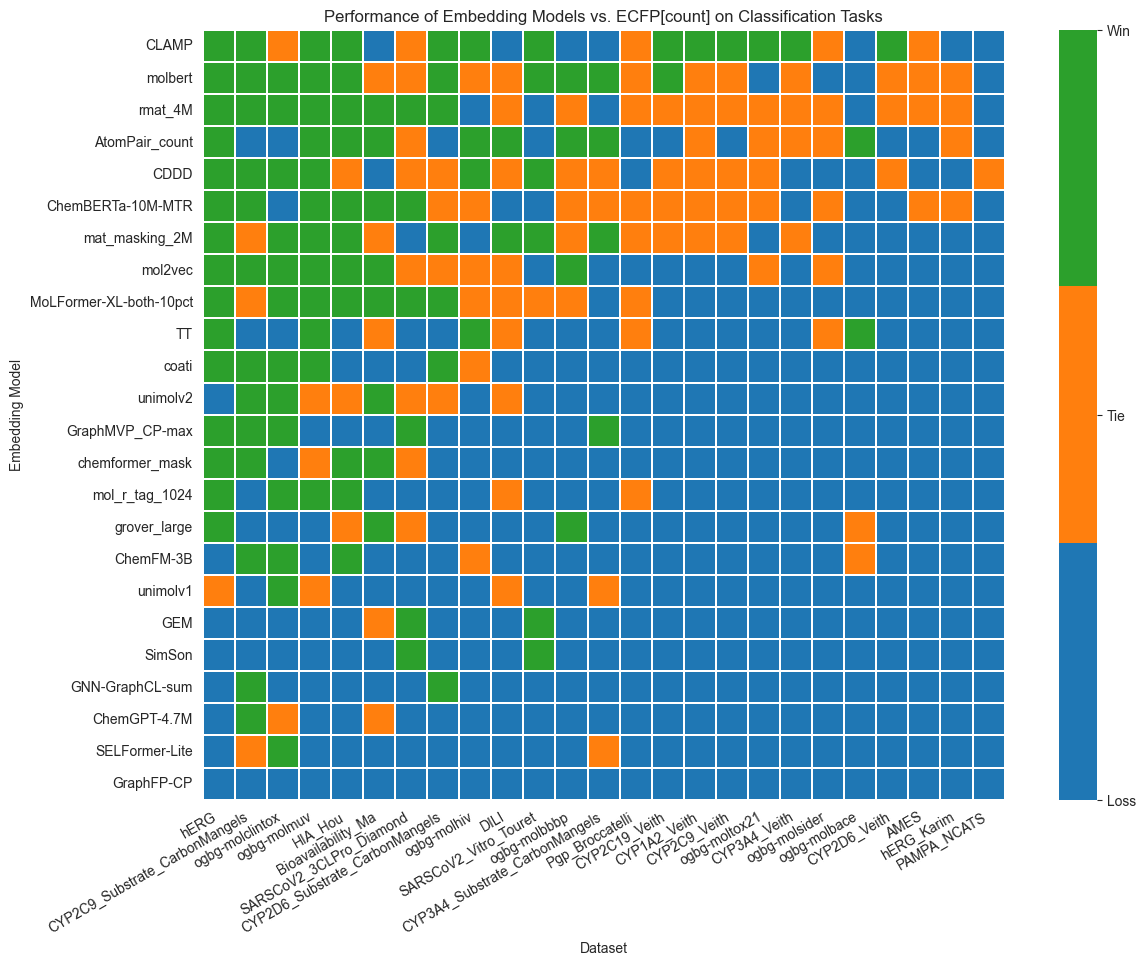

In [25]:
sns.set_style(style="whitegrid")
p = df4[df4['embedder'] != 'ECFP_count'].pivot(
    index='embedder',
    columns='dataset',
    values='significant_win_bin'
)

p = p.loc[[x for x in embedder_order if x in p.index], [x for x in dataset_order if x in p.columns]]

palette = sns.color_palette('tab10', 3)

ax = sns.heatmap(
    p,
    cmap=palette,
    square=True,
    linewidths=0.1,
)

cbar = ax.collections[0].colorbar
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['Loss', 'Tie', 'Win'])

plt.gcf().set_size_inches(14, 10)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Dataset')
plt.ylabel('Embedding Model')
plt.title('Performance of Embedding Models vs. ECFP[count] on Classification Tasks')
_ = ''

In [26]:
df4.head()

,embedder,dataset,test_metric,ecfp,significant_win,significant_win_bin,gain
0,AtomPair_count,AMES,0.814525,0.84817,Loss,-1,-0.039667
1,CDDD,AMES,0.835524,0.84817,Loss,-1,-0.014909
2,CLAMP,AMES,0.845998,0.84817,Tie,0,-0.002561
3,ChemBERTa-10M-MTR,AMES,0.842645,0.84817,Tie,0,-0.006514
4,ChemFM-3B,AMES,0.819407,0.84817,Loss,-1,-0.033912


## Models cross win rate plot

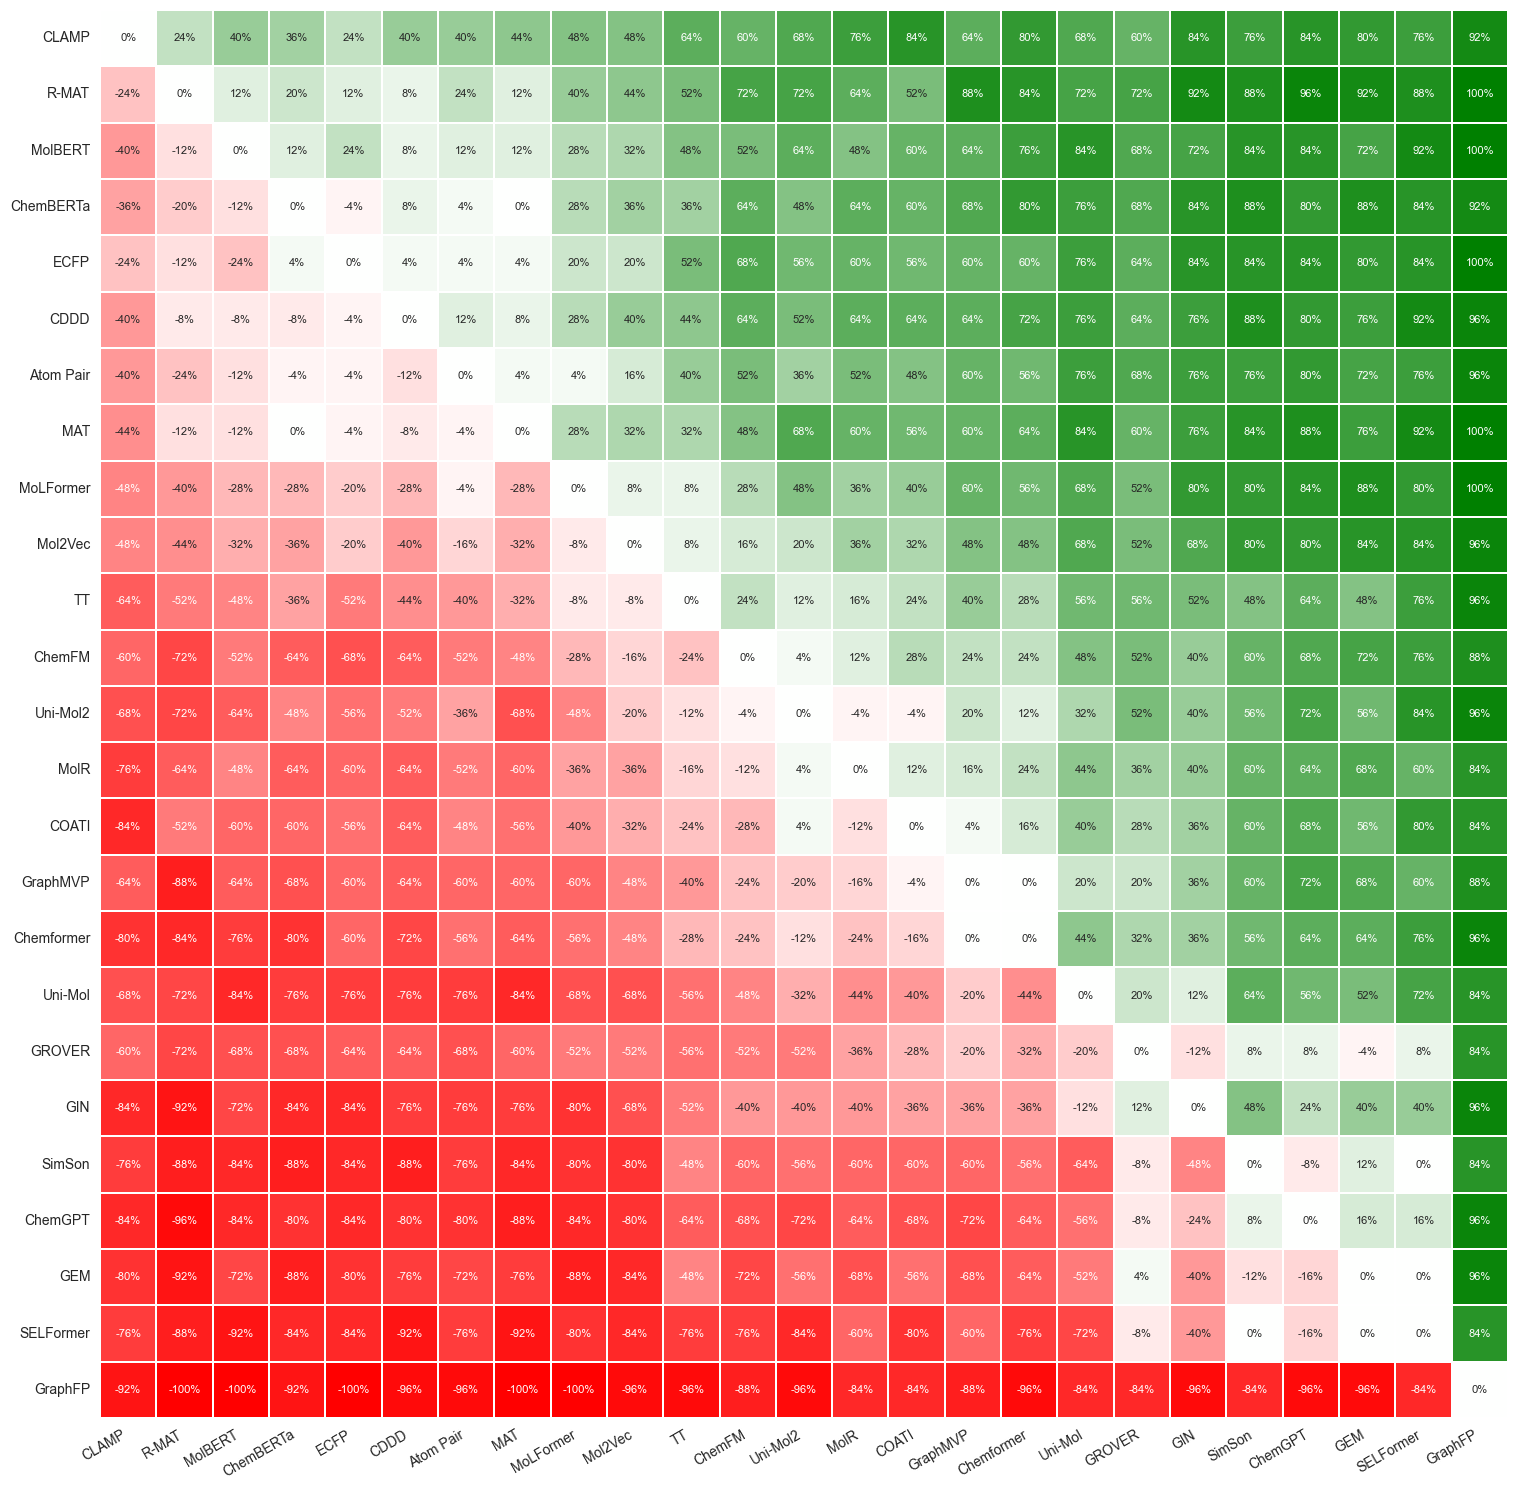

In [27]:
from matplotlib.colors import LinearSegmentedColormap

winrate = df4.merge(
    df4,
    on='dataset',
    suffixes=('_index', '_column')
)

winrate['won'] = np.where(
    (winrate['test_metric_index'] - winrate['test_metric_column']).abs() < 0.01,
    'Tie',
    np.where(
        winrate['test_metric_index'] > winrate['test_metric_column'],
        'Win',
        'Loss'
    )
)
winrate['won_bin'] = winrate['won'].map({
    'Win': 1,
    'Loss': -1,
    'Tie': 0
})

p_win = winrate.groupby(
    ['embedder_index', 'embedder_column']
)['won_bin'].mean().reset_index().pivot(
    index='embedder_index',
    columns='embedder_column',
    values='won_bin'
)

p_win = p_win.loc[[x for x in embedder_order if x in p_win.index], [x for x in embedder_order if x in p_win.columns]]

p_win.index = p_win.index.map(names)
p_win.columns = p_win.columns.map(names)

p_win = p_win.loc[order_new, order_new]

custom_cmap = LinearSegmentedColormap.from_list('custom_diverging', ['red', 'white', 'green'])

sns.heatmap(
    p_win,
    cmap=custom_cmap,
    linewidths=0.1,
    square=True,
    annot=True,
    fmt='.0%',
    annot_kws={"size": 8},
    cbar=False,
)

# plt.title('Cross-winrate of models (rows) over models (columns) \n Mean[[1 if A > B, -1 if B > A, 0 if Tie ]]', fontsize=16)
# plt.xlabel('Model B', fontsize=14, fontweight='bold')
# plt.ylabel('Model A', fontsize=14, fontweight='bold')
# plt.title('Cross-winrate of models (rows) over models (columns)\nMean[[1 if A > B, -1 if B > A, 0 if Tie ]]', fontsize=16, fontweight='bold')
# plt.xlabel('Model B')
# plt.ylabel('Model A')
plt.xlabel(None)
plt.ylabel(None)
plt.gcf().set_size_inches(20, 15)

plt.xticks(np.arange(len(p_win.columns)) + 0.5, labels=p_win.columns, rotation=30, ha='right')
plt.yticks(np.arange(len(p_win.index)) + 0.5, labels=p_win.index, rotation=0)
plt.gcf().tight_layout()
# plt.gcf().axes[-1].set_position([0.2, 0.08, 0.6, 0.01])

# plt.gcf().colorbar(
#     plt.gcf().axes[-2].collections[0],
#     ax=plt.gcf().axes[-2],
#     orientation='horizontal',
#     fraction=0.046, pad=0.13
# )
# plt.gcf().axes[-1].set_title('Cross-winrate', fontsize=12)
plt.savefig('cross_winrate.png', dpi=400, bbox_inches='tight')

In [28]:
df4['won_with_ecfp'] = (df4['test_metric'] - df4['ecfp']) > 0.01
df4.head()

,embedder,dataset,test_metric,ecfp,significant_win,significant_win_bin,gain,won_with_ecfp
0,AtomPair_count,AMES,0.814525,0.84817,Loss,-1,-0.039667,False
1,CDDD,AMES,0.835524,0.84817,Loss,-1,-0.014909,False
2,CLAMP,AMES,0.845998,0.84817,Tie,0,-0.002561,False
3,ChemBERTa-10M-MTR,AMES,0.842645,0.84817,Tie,0,-0.006514,False
4,ChemFM-3B,AMES,0.819407,0.84817,Loss,-1,-0.033912,False


In [29]:
best_score = df4.groupby('dataset')['test_metric'].max().reset_index().rename(columns={'test_metric': 'best_score'})
df5 = df4.merge(best_score, on='dataset')
df5['within_top'] = (df5['best_score'] - df5['test_metric']) < 0.01
u = df5.groupby('embedder')['within_top'].sum().sort_values(ascending=False)
u

embedder
CLAMP                      14
AtomPair_count              7
rmat_4M                     6
ECFP_count                  5
ChemBERTa-10M-MTR           5
molbert                     4
CDDD                        3
grover_large                2
TT                          2
mol2vec                     2
mat_masking_2M              2
ChemFM-3B                   1
mol_r_tag_1024              1
GraphMVP_CP-max             1
MoLFormer-XL-both-10pct     1
SimSon                      1
unimolv1                    0
SELFormer-Lite              0
coati                       0
chemformer_mask             0
GraphFP-CP                  0
GNN-GraphCL-sum             0
GEM                         0
ChemGPT-4.7M                0
unimolv2                    0
Name: within_top, dtype: int64

In [30]:
df5['embedder'].unique()

array(['AtomPair_count', 'CDDD', 'CLAMP', 'ChemBERTa-10M-MTR',
       'ChemFM-3B', 'ChemGPT-4.7M', 'ECFP_count', 'GEM',
       'GNN-GraphCL-sum', 'GraphFP-CP', 'GraphMVP_CP-max',
       'MoLFormer-XL-both-10pct', 'SELFormer-Lite', 'SimSon', 'TT',
       'chemformer_mask', 'coati', 'grover_large', 'mat_masking_2M',
       'mol2vec', 'mol_r_tag_1024', 'molbert', 'rmat_4M', 'unimolv1',
       'unimolv2'], dtype=object)

In [31]:
df5[(df5['embedder'].isin(['AtomPair_count', 'ECFP_count', 'TT']))].groupby('dataset')['within_top'].max().mean()

0.4

In [32]:
v = df5[df5['within_top']].groupby('dataset').size().sort_values(ascending=False)
v

dataset
Pgp_Broccatelli                   7
ogbg-molsider                     6
hERG_Karim                        5
AMES                              4
CYP3A4_Substrate_CarbonMangels    4
HIA_Hou                           3
ogbg-molbace                      3
SARSCoV2_Vitro_Touret             3
ogbg-molbbbp                      2
SARSCoV2_3CLPro_Diamond           2
PAMPA_NCATS                       2
DILI                              2
CYP2C9_Substrate_CarbonMangels    2
Bioavailability_Ma                1
CYP3A4_Veith                      1
CYP2D6_Veith                      1
CYP2D6_Substrate_CarbonMangels    1
hERG                              1
CYP2C9_Veith                      1
CYP2C19_Veith                     1
ogbg-molclintox                   1
ogbg-molhiv                       1
ogbg-molmuv                       1
CYP1A2_Veith                      1
ogbg-moltox21                     1
dtype: int64

In [33]:
df5[df5['within_top'] & (df5['dataset'].isin(v[(v > 1)].index))].sort_values(by=['embedder', 'dataset'])

,embedder,dataset,test_metric,ecfp,significant_win,significant_win_bin,gain,won_with_ecfp,best_score,within_top
200,AtomPair_count,CYP3A4_Substrate_CarbonMangels,0.683996,0.663766,Win,1,0.030478,True,0.683996,True
250,AtomPair_count,DILI,0.928696,0.915217,Win,1,0.014727,True,0.935217,True
275,AtomPair_count,HIA_Hou,0.986831,0.949794,Win,1,0.038995,True,0.992593,True
425,AtomPair_count,hERG_Karim,0.870702,0.878392,Tie,0,-0.008754,False,0.878392,True
450,AtomPair_count,ogbg-molbace,0.870979,0.859677,Win,1,0.013147,True,0.873066,True
475,AtomPair_count,ogbg-molbbbp,0.738137,0.720100,Win,1,0.025047,True,0.742622,True
575,AtomPair_count,ogbg-molsider,0.686927,0.686362,Tie,0,0.000823,False,0.692175,True
301,CDDD,PAMPA_NCATS,0.762297,0.764460,Tie,0,-0.002830,False,0.764460,True
376,CDDD,SARSCoV2_Vitro_Touret,0.627695,0.593887,Win,1,0.056926,True,0.632405,True
2,CLAMP,AMES,0.845998,0.848170,Tie,0,-0.002561,False,0.855419,True


In [34]:
df5[df5['within_top'] & (df5['dataset'].isin(v[(v == 1)].index))]

,embedder,dataset,test_metric,ecfp,significant_win,significant_win_bin,gain,won_with_ecfp,best_score,within_top
42,grover_large,Bioavailability_Ma,0.883937,0.691054,Win,1,0.279115,True,0.883937,True
52,CLAMP,CYP1A2_Veith,0.950784,0.927867,Win,1,0.024699,True,0.950784,True
77,CLAMP,CYP2C19_Veith,0.922305,0.874444,Win,1,0.054733,True,0.922305,True
127,CLAMP,CYP2C9_Veith,0.915555,0.881943,Win,1,0.038111,True,0.915555,True
152,CLAMP,CYP2D6_Substrate_CarbonMangels,0.843150,0.804727,Win,1,0.047746,True,0.843150,True
177,CLAMP,CYP2D6_Veith,0.893452,0.872068,Win,1,0.024521,True,0.893452,True
227,CLAMP,CYP3A4_Veith,0.903643,0.875122,Win,1,0.032592,True,0.903643,True
417,grover_large,hERG,0.953002,0.804579,Win,1,0.184473,True,0.953002,True
501,CDDD,ogbg-molclintox,0.936142,0.762966,Win,1,0.226976,True,0.936142,True
527,CLAMP,ogbg-molhiv,0.931127,0.789324,Win,1,0.179651,True,0.931127,True


In [35]:
(u).count()

25

In [36]:
o = df4.groupby('dataset')['won_with_ecfp'].mean().sort_values(ascending=False)
o

dataset
hERG                              0.60
ogbg-molclintox                   0.52
CYP2C9_Substrate_CarbonMangels    0.52
ogbg-molmuv                       0.48
HIA_Hou                           0.44
Bioavailability_Ma                0.32
CYP2D6_Substrate_CarbonMangels    0.28
SARSCoV2_3CLPro_Diamond           0.24
SARSCoV2_Vitro_Touret             0.24
ogbg-molbbbp                      0.16
CYP3A4_Substrate_CarbonMangels    0.16
ogbg-molhiv                       0.16
ogbg-molbace                      0.08
DILI                              0.08
CYP2C19_Veith                     0.08
CYP3A4_Veith                      0.04
CYP2D6_Veith                      0.04
CYP2C9_Veith                      0.04
CYP1A2_Veith                      0.04
ogbg-moltox21                     0.04
ogbg-molsider                     0.00
AMES                              0.00
hERG_Karim                        0.00
Pgp_Broccatelli                   0.00
PAMPA_NCATS                       0.00
Name: won_with_ec

## Models outperforming ECFP per dataset

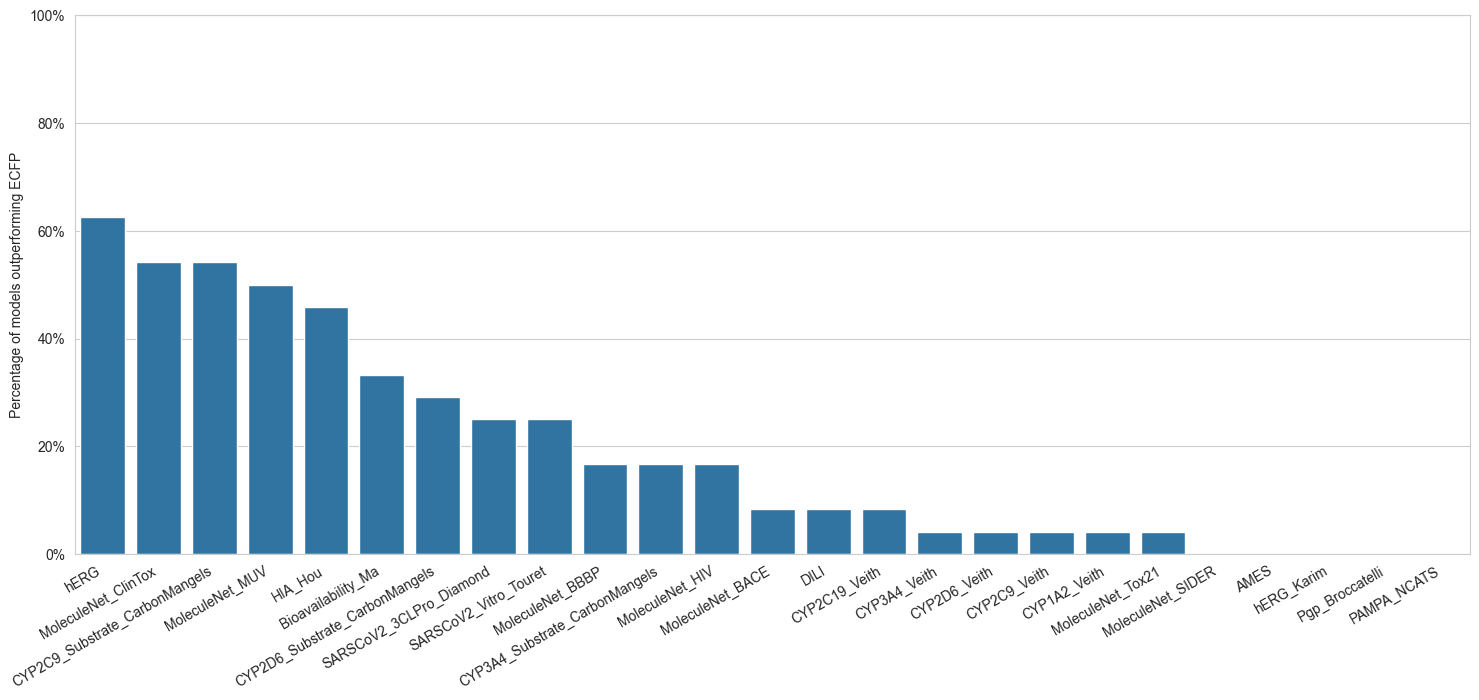

In [37]:
from matplotlib import ticker as mtick

new_names = {
    'ogbg-molclintox': 'MoleculeNet_ClinTox',
    'ogbg-molmuv': 'MoleculeNet_MUV',
    'ogbg-molbbbp' : 'MoleculeNet_BBBP',
    'ogbg-molhiv': 'MoleculeNet_HIV',
    'ogbg-molbace': 'MoleculeNet_BACE',
    'ogbg-moltox21': 'MoleculeNet_Tox21',
    'ogbg-molsider': 'MoleculeNet_SIDER',
}

dataset_scores = df4[df4['embedder'] != 'ECFP_count'].groupby('dataset')['won_with_ecfp'].mean().sort_values(ascending=False).reset_index()

dataset_scores['dataset'] = dataset_scores['dataset'].replace(new_names)

sns.barplot(
    dataset_scores,
    x='dataset',
    y='won_with_ecfp',
)

plt.xticks(rotation=30, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.gcf().set_size_inches(18, 7)
plt.ylim(0, 1)
plt.ylabel('Percentage of models outperforming ECFP')
plt.xlabel(None)
plt.savefig('dataset_winrate.png', dpi=300, bbox_inches='tight')

In [38]:
candidate_models

['AtomPair_count',
 'CDDD',
 'CLAMP',
 'ChemBERTa-10M-MTR',
 'ChemFM-3B',
 'ChemGPT-4.7M',
 'ECFP_count',
 'GEM',
 'GNN-GraphCL-sum',
 'GraphFP-CP',
 'GraphMVP_CP-max',
 'MoLFormer-XL-both-10pct',
 'SELFormer-Lite',
 'SimSon',
 'TT',
 'chemformer_mask',
 'coati',
 'grover_large',
 'mat_masking_2M',
 'mol2vec',
 'mol_r_tag_1024',
 'molbert',
 'rmat_4M',
 'unimolv1',
 'unimolv2']

## All models number of wins or near wins

In [39]:
df3.head()

,embedder,dataset,test_metric
25,AtomPair_count,AMES,0.814525
26,AtomPair_count,Bioavailability_Ma,0.712005
27,AtomPair_count,CYP1A2_Veith,0.928864
28,AtomPair_count,CYP2C19_Veith,0.858162
29,AtomPair_count,CYP2C9_Substrate_CarbonMangels,0.596310


In [40]:
winning_score = df3.groupby('dataset')['test_metric'].max().reset_index().rename(columns={'test_metric': 'winning_score'})
df3 = df3.merge(winning_score, on='dataset')
df3['near_win'] = (df3['winning_score'] - df3['test_metric']) < 0.01
df3.head()

,embedder,dataset,test_metric,winning_score,near_win
0,AtomPair_count,AMES,0.814525,0.855419,False
1,CDDD,AMES,0.835524,0.855419,False
2,CLAMP,AMES,0.845998,0.855419,True
3,ChemBERTa-10M-MTR,AMES,0.842645,0.855419,False
4,ChemFM-3B,AMES,0.819407,0.855419,False


In [41]:
near_wins_per_dataset = df3.groupby('embedder')['near_win'].sum().sort_values(ascending=False).reset_index()
near_wins_per_dataset['Model'] = near_wins_per_dataset['embedder'].map(model_mapping)
near_wins_per_dataset.head()
near_wins_per_dataset['Number of datasets'] = near_wins_per_dataset['near_win']
near_wins_per_dataset = near_wins_per_dataset[['Model', 'Number of datasets']]
near_wins_per_dataset.to_latex('near_wins.tex', index=False)
near_wins_per_dataset

/var/folders/hs/250xkhr95fg75n5m5v0nr64c0000gn/T/ipykernel_24523/4031101132.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  near_wins_per_dataset.to_latex('near_wins.tex', index=False)


,Model,Number of datasets
0,CLAMP,14
1,AtomPair,7
2,RMAT,6
3,ECFP,5
4,ChemBERTa,5
5,MolBERT,4
6,CDDD,3
7,Grover,2
8,TT,2
9,Mol2Vec,2


## Different variants performance comparison

In [42]:
df['embedder'].unique()

array(['CDDD', 'AtomPair', 'TT', 'ECFP', 'AtomPair_count', 'TT_count',
       'ECFP_count', 'CLAMP', 'unimolv2', 'unimolv1', 'molbert',
       'mat_masking_200k', 'mat_masking_2M', 'grover_base',
       'mat_masking_20M', 'grover_large', 'rmat_4M', 'mol2vec',
       'chemformer_augment', 'chemformer_mask', 'chemformer_combined',
       'ChemBERTa-10M-MTR', 'ChemBERTa-5M-MTR', 'ChemBERTa-5M-MLM',
       'ChemBERTa-10M-MLM', 'ChemBERTa-77M-MLM', 'ChemBERTa-77M-MTR',
       'ChemFM-1B', 'ChemGPT-4.7M', 'ChemGPT-19M',
       'MoLFormer-XL-both-10pct', 'SELFormer', 'ChemFM-3B',
       'SELFormer-Lite', 'mol_r_tag_1024', 'mol_r_gcn_1024',
       'mol_r_gat_1024', 'mol_r_sage_1024', 'GEM', 'coati',
       'GraphMVP_CP-max', 'GraphMVP_CP-sum', 'GraphMVP_AM-sum',
       'GraphMVP_CP-mean', 'GraphMVP_AM-max', 'GraphMVP_AM-mean',
       'GNN-AM-sum', 'GraphFP-CP', 'GraphFP-C', 'GNN-CP-sum',
       'GNN-EP-sum', 'SimSon', 'GNN-GraphCL-sum', 'GNN-Contextual-sum',
       'GNN-IG-sum', 'GNN-GPT_TNN-s

In [43]:
names_full = names = {
    'CDDD': 'CDDD',
    'AtomPair': 'Atom Pair',
    'AtomPair_count': 'Atom Pair [Count]',
    'TT': 'TT',
    'TT_count': 'TT [Count]',
    'ECFP': 'ECFP',
    'ECFP_count': 'ECFP [Count]',
    'CLAMP': 'CLAMP',
    'unimolv2': 'Uni-Mol2',
    'unimolv1': 'Uni-Mol',
    'molbert': 'MolBERT',
    'mat_masking_200k': 'MAT [200k]',
    'mat_masking_2M': 'MAT [2M]',
    'mat_masking_20M': 'MAT [20M]',
    'grover_base': 'GROVER [Base]',
    'grover_large': 'GROVER [Large]',
    'rmat_4M': 'R-MAT [4M]',
    'mol2vec': 'Mol2Vec',
    'chemformer_augment': 'Chemformer [Augment]',
    'chemformer_mask': 'Chemformer [Mask]',
    'chemformer_combined': 'Chemformer [Combined]',
    'ChemBERTa-10M-MTR': 'ChemBERTa [10M][MTR]',
    'ChemBERTa-5M-MTR': 'ChemBERTa [5M][MTR]',
    'ChemBERTa-5M-MLM': 'ChemBERTa [5M][MLM]',
    'ChemBERTa-10M-MLM': 'ChemBERTa [10M][MLM]',
    'ChemBERTa-77M-MLM': 'ChemBERTa [77M][MLM]',
    'ChemBERTa-77M-MTR': 'ChemBERTa [77M][MTR]',
    'ChemFM-1B_avg': 'ChemFM [1B][Avg]',
    'ChemFM-1B': 'ChemFM [1B]',
    'ChemFM-3B_avg': 'ChemFM [3B][Avg]',
    'ChemFM-3B': 'ChemFM [3B]',
    'ChemGPT-4.7M': 'ChemGPT [4.7M]',
    'ChemGPT-19M': 'ChemGPT [19M]',
    'MoLFormer-XL-both-10pct': 'MoLFormer',
    'SELFormer': 'SELFormer',
    'SELFormer-Lite': 'SELFormer [Lite]',
    'mol_r_tag_1024': 'MolR [TAG][1024]',
    'mol_r_gcn_1024': 'MolR [GCN][1024]',
    'mol_r_gat_1024': 'MolR [GAT][1024]',
    'mol_r_sage_1024': 'MolR [SAGE][1024]',
    'GEM': 'GEM',
    'coati': 'COATI',
    'GraphMVP_CP-max': 'GraphMVP [CP][Max]',
    'GraphMVP_CP-sum': 'GraphMVP [CP][Sum]',
    'GraphMVP_CP-mean': 'GraphMVP [CP][Mean]',
    'GraphMVP_AM-max': 'GraphMVP [AM][Max]',
    'GraphMVP_AM-sum': 'GraphMVP [AM][Sum]',
    'GraphMVP_AM-mean': 'GraphMVP [AM][Mean]',
    'GNN-AM-sum': 'GIN [AM][Sum]',
    'GraphFP-CP': 'GraphFP [CP]',
    'GraphFP-C': 'GraphFP [C]',
    'GNN-CP-sum': 'GIN [CP][Sum]',
    'GNN-EP-sum': 'GIN [EP][Sum]',
    'SimSon': 'SimSon',
    'GNN-GraphCL-sum': 'GIN [GraphCL][Sum]',
    'GNN-Contextual-sum': 'GIN [Contextual][Sum]',
    'GNN-IG-sum': 'GIN [IG][Sum]',
    'GNN-GPT_TNN-sum': 'GIN [GPT_TNN][Sum]',
    'GNN-Motif-sum': 'GIN [Motif][Sum]',
}

set(df['embedder'].unique()) - set(names_full.keys())

set()

In [44]:
# rank_data = df[df['embedder'].isin(models_to_use) & (~df['dataset'].isin(['ogbg-molhiv', 'ClinTox']))]
rank_data = df.copy()
# rank_data['n_metric'] = rank_data['normalized_metric'].round(2)

best = rank_data.groupby(['dataset', 'embedder'])['test_metric'].max().reset_index()
best['model'] = 'best'

rank_data = pd.concat([
    rank_data,
    best,
])

rank_data['rank'] = rank_data.groupby(['dataset', 'model'])['test_metric'].rank(ascending=False, method='average')
perf = rank_data.groupby(['embedder', 'model'])[['rank', 'test_metric']].mean().reset_index().melt(id_vars=['embedder', 'model'], var_name='metric', value_name='value').pivot(
    index='embedder', columns=['metric', 'model'], values='value'
)

# Round all 'rank' columns to 2 decimal places
perf.loc[:, perf.columns.get_level_values(0) == 'rank'] = perf.loc[:, perf.columns.get_level_values(0) == 'rank'].applymap(lambda x: round(x, 2))

# Format all 'test_metric' columns as percentages with 2 decimals
perf.loc[:, perf.columns.get_level_values(0) == 'test_metric'] = perf.loc[:, perf.columns.get_level_values(0) == 'test_metric'].applymap(lambda x: f"{x:.2%}")

perf = perf.sort_values(by=('rank', 'best'), ascending=True).reset_index()
perf[('embedder', '')] = perf[('embedder', '')].map(names_full)
perf.to_latex('full_table.tex', index=False)
perf

/var/folders/hs/250xkhr95fg75n5m5v0nr64c0000gn/T/ipykernel_24523/658725100.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  perf.to_latex('full_table.tex', index=False)


metric               embedder   rank                      test_metric          \
model                           best    knn     rf  ridge        best     knn   
0                       CLAMP   8.84   8.78   9.08   9.58      82.55%  77.77%   
1                  R-MAT [4M]   8.96   9.70   8.78   8.44      80.83%  76.79%   
2                     MolBERT  11.04  10.70   8.94  10.84      80.51%  76.76%   
3        ChemBERTa [10M][MTR]  11.64  10.17  12.04  14.36      79.99%  76.55%   
4                ECFP [Count]  11.78  27.04   9.86  17.80      79.89%  71.93%   
5                        CDDD  12.42  11.17  11.16  16.28      80.60%  76.56%   
6                    MAT [2M]  12.70  14.43  13.80  12.62      80.18%  76.25%   
7           Atom Pair [Count]  13.42  14.04  13.68  18.12      79.48%  75.46%   
8        ChemBERTa [77M][MTR]  13.86  12.04  13.92  15.28      79.48%  76.13%   
9         ChemBERTa [5M][MTR]  14.38  10.91  13.88  18.60      79.64%  76.57%   
10                  MAT [20M]  15.00  14.30  16.52  12.44      79.67%  76.06%   
11                  MoLFormer  15.42  11.48  15.96  21.28      79.80%  76.09%   
12                    Mol2Vec  16.92  18.22  16.52  17.28      79.55%  74.21%   
13                       ECFP  17.82  25.96  16.00  18.74      78.94%  72.21%   
14                  Atom Pair  18.44  16.65  16.32  18.44      78.60%  74.50%   
15                 MAT [200k]  18.64  23.26  21.26  12.72      79.10%  73.52%   
16                 TT [Count]  20.32  31.78  19.28  25.00      78.08%  70.93%   
17                         TT  21.04  25.48  18.88  22.80      78.12%  72.10%   
18                ChemFM [3B]  22.48  27.70  33.92  15.36      78.25%  72.73%   
19                   Uni-Mol2  23.76  29.61  27.92  19.40      78.11%  71.61%   
20           MolR [TAG][1024]  24.20  22.61  23.22  22.04      77.84%  73.83%   
21                      COATI  24.62  23.30  24.00  23.40      78.02%  72.80%   
22          Chemformer [Mask]  25.68  23.43  26.92  22.28      77.44%  73.26%   
23         GraphMVP [CP][Max]  26.64  18.35  23.72  35.32      77.18%  74.62%   
24         GraphMVP [AM][Max]  27.40  28.78  23.20  33.94      77.13%  71.95%   
25       ChemBERTa [10M][MLM]  28.28  31.61  26.68  29.48      76.46%  71.46%   
26      Chemformer [Combined]  29.04  28.39  34.40  23.60      76.86%  72.13%   
27           MolR [GAT][1024]  29.16  29.13  28.38  28.20      76.72%  71.84%   
28          MolR [SAGE][1024]  29.48  30.91  30.12  27.60      77.04%  71.82%   
29           MolR [GCN][1024]  30.84  28.39  28.74  28.52      76.59%  72.74%   
30                ChemFM [1B]  30.96  37.76  39.12  23.64      76.07%  68.95%   
31                    Uni-Mol  31.04  25.65  28.20  26.08      76.85%  72.94%   
32         GraphMVP [CP][Sum]  32.74  26.78  32.92  33.56      75.58%  72.01%   
33         GIN [GraphCL][Sum]  33.00  30.83  29.40  35.24      75.14%  70.80%   
34         GraphMVP [AM][Sum]  33.68  27.28  32.44  35.26      75.29%  71.82%   
35             GROVER [Large]  34.16  43.30  38.78  30.90      75.68%  66.55%   
36       Chemformer [Augment]  35.32  40.09  38.68  32.72      75.32%  67.66%   
37              GROVER [Base]  35.72  41.17  37.32  33.64      75.21%  67.77%   
38        GraphMVP [CP][Mean]  36.32  31.00  36.48  37.40      74.76%  71.08%   
39        GraphMVP [AM][Mean]  36.50  30.26  35.48  40.12      74.17%  70.84%   
40      GIN [Contextual][Sum]  36.60  34.35  34.98  37.56      74.47%  70.11%   
41        ChemBERTa [5M][MLM]  37.88  37.83  34.66  36.16      74.20%  69.19%   
42              ChemGPT [19M]  38.38  33.61  37.78  38.36      73.77%  70.84%   
43       ChemBERTa [77M][MLM]  39.00  40.20  39.14  36.40      72.92%  67.43%   
44             ChemGPT [4.7M]  39.40  35.13  36.84  40.72      74.01%  70.09%   
45                     SimSon  39.52  33.26  40.16  43.66      73.56%  70.80%   
46                        GEM  39.72  31.57  38.52  39.96      74.03%  71.75%   
47              GIN [IG][Sum]  

## ChemBERTa MTR vs MLM performance

In [45]:
perf_chemberta = perf[perf[('embedder', '')].str.contains('ChemBERTa')]
perf_chemberta

metric              embedder   rank                      test_metric          \
model                          best    knn     rf  ridge        best     knn   
3       ChemBERTa [10M][MTR]  11.64  10.17  12.04  14.36      79.99%  76.55%   
8       ChemBERTa [77M][MTR]  13.86  12.04  13.92  15.28      79.48%  76.13%   
9        ChemBERTa [5M][MTR]  14.38  10.91  13.88  18.60      79.64%  76.57%   
25      ChemBERTa [10M][MLM]  28.28  31.61  26.68  29.48      76.46%  71.46%   
41       ChemBERTa [5M][MLM]  37.88  37.83  34.66  36.16      74.20%  69.19%   
43      ChemBERTa [77M][MLM]  39.00  40.20  39.14  36.40      72.92%  67.43%   

metric                  
model       rf   ridge  
3       78.75%  77.91%  
8       78.20%  77.58%  
9       78.46%  77.01%  
25      74.89%  74.24%  
41      73.64%  72.63%  
43      71.28%  71.14%

In [46]:
df_chemberta = df2[df2['embedder'].str.contains('ChemBERTa')]
df_chemberta.head()

,embedder,dataset,test_metric
100,ChemBERTa-10M-MLM,AMES,0.748936
101,ChemBERTa-10M-MLM,Bioavailability_Ma,0.670269
102,ChemBERTa-10M-MLM,CYP1A2_Veith,0.894656
103,ChemBERTa-10M-MLM,CYP2C19_Veith,0.836867
104,ChemBERTa-10M-MLM,CYP2C9_Substrate_CarbonMangels,0.661422


In [47]:
winrate

,embedder_index,dataset,test_metric_index,ecfp_index,significant_win_index,significant_win_bin_index,gain_index,embedder_column,test_metric_column,ecfp_column,significant_win_column,significant_win_bin_column,gain_column,won,won_bin
0,AtomPair_count,AMES,0.814525,0.848170,Loss,-1,-0.039667,AtomPair_count,0.814525,0.848170,Loss,-1,-0.039667,Tie,0
1,AtomPair_count,AMES,0.814525,0.848170,Loss,-1,-0.039667,CDDD,0.835524,0.848170,Loss,-1,-0.014909,Loss,-1
2,AtomPair_count,AMES,0.814525,0.848170,Loss,-1,-0.039667,CLAMP,0.845998,0.848170,Tie,0,-0.002561,Loss,-1
3,AtomPair_count,AMES,0.814525,0.848170,Loss,-1,-0.039667,ChemBERTa-10M-MTR,0.842645,0.848170,Tie,0,-0.006514,Loss,-1
4,AtomPair_count,AMES,0.814525,0.848170,Loss,-1,-0.039667,ChemFM-3B,0.819407,0.848170,Loss,-1,-0.033912,Tie,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15620,unimolv2,ogbg-moltox21,0.725048,0.781798,Loss,-1,-0.072588,mol_r_tag_1024,0.770395,0.781798,Loss,-1,-0.014586,Loss,-1
15621,unimolv2,ogbg-moltox21,0.725048,0.781798,Loss,-1,-0.072588,molbert,0.763896,0.781798,Loss,-1,-0.022899,Loss,-1
15622,unimolv2,ogbg-moltox21,0.725048,0.781798,Loss,-1,-0.072588,rmat_4M,0.779766,0.781798,Tie,0,-0.002599,Loss,-1
15623,unimolv2,ogbg-moltox21,0.725048,0.781798,Loss,-1,-0.072588,unimolv1,0.749670,0.781798,Loss,-1,-0.041095,Loss,-1


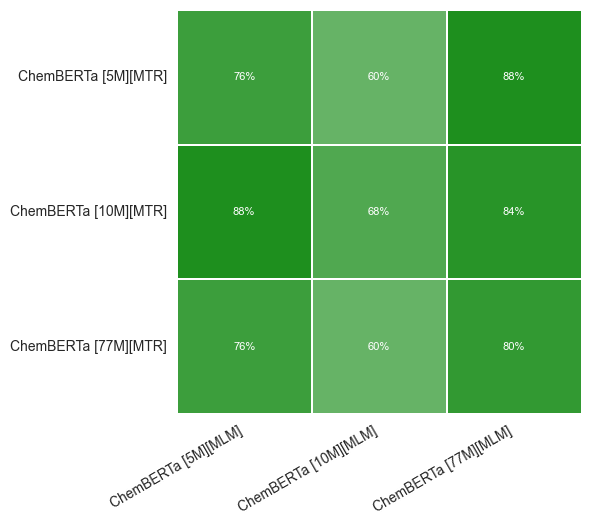

In [48]:
winrate = df_chemberta[df_chemberta['embedder'].str.contains('MTR')].merge(
    df_chemberta[df_chemberta['embedder'].str.contains('MLM')],
    on='dataset',
    suffixes=('_mtr', '_mlm')
)

winrate['embedder_mtr'] = winrate['embedder_mtr'].map(names_full)
winrate['embedder_mlm'] = winrate['embedder_mlm'].map(names_full)

winrate['mtr_winrate'] = np.where(
    (winrate['test_metric_mtr'] - winrate['test_metric_mlm']).abs() < 0.01,
    'Tie',
    np.where(
        winrate['test_metric_mtr'] > winrate['test_metric_mlm'],
        'Win',
        'Loss'
    )
)
winrate['won_bin'] = winrate['mtr_winrate'].map({
    'Win': 1,
    'Loss': -1,
    'Tie': 0
})

p_win = winrate.groupby(
    ['embedder_mtr', 'embedder_mlm']
)['won_bin'].mean().reset_index().pivot(
    index='embedder_mtr',
    columns='embedder_mlm',
    values='won_bin'
)

row_order = [
    'ChemBERTa [5M][MTR]',
    'ChemBERTa [10M][MTR]',
    'ChemBERTa [77M][MTR]',
]
col_order = [
    'ChemBERTa [5M][MLM]',
    'ChemBERTa [10M][MLM]',
    'ChemBERTa [77M][MLM]',
]

p_win = p_win.loc[row_order, col_order]

custom_cmap = LinearSegmentedColormap.from_list('custom_diverging', ['red', 'white', 'green'])

sns.heatmap(
    p_win,
    cmap=custom_cmap,
    linewidths=0.1,
    square=True,
    annot=True,
    fmt='.0%',
    annot_kws={"size": 8},
    cbar=False,
    vmin=-1,
    vmax=1
)

plt.xlabel(None)
plt.ylabel(None)
plt.gcf().set_size_inches(6, 6)

plt.xticks(np.arange(len(p_win.columns)) + 0.5, labels=p_win.columns, rotation=30, ha='right')
plt.yticks(np.arange(len(p_win.index)) + 0.5, labels=p_win.index, rotation=0)
plt.gcf().tight_layout()
plt.savefig('cross_winrate_chemberta.png', dpi=400, bbox_inches='tight')

## Datasets descriptions

In [107]:
import joblib

with open('config/illegal_smiles.txt', 'r') as f:
    illegal_smiles = f.read().splitlines()

def task_overview(name):
    file = f"data/prepared/{name}.joblib"
    obj = joblib.load(file)
    obj_df = obj.data
    obj_df = obj_df[~obj_df['smiles'].isin(illegal_smiles)]
    y_names = obj.labels.columns.tolist()
    obj_y = obj_df[y_names]
    obj_x = obj_df['smiles']
    negative_samples = 0
    positive_samples = 0
    for col in y_names:
        positive_samples += (obj_df[col] == 1).sum()
        negative_samples += (obj_df[col] == 0).sum()
    
    return {
        "name": name,
        "num_samples": len(obj_x),
        "no_tasks": len(y_names),
        "positive_samples_ratio": positive_samples / (positive_samples + negative_samples),
    }

In [117]:
datasets = df3['dataset'].unique().tolist()

In [118]:
rows = []
for dataset in datasets:
    rows.append(task_overview(dataset))
overview_df = pd.DataFrame(rows)
overview_df.head()

,name,num_samples,no_tasks,positive_samples_ratio
0,AMES,7278,1,0.546029
1,Bioavailability_Ma,640,1,0.768750
2,CYP1A2_Veith,12579,1,0.463391
3,CYP2C19_Veith,12665,1,0.459455
4,CYP2C9_Substrate_CarbonMangels,669,1,0.210762


In [120]:
overview_df['name'] = overview_df['name'].replace(new_names)
overview_df.head()

,name,num_samples,no_tasks,positive_samples_ratio
0,AMES,7278,1,0.546029
1,Bioavailability_Ma,640,1,0.768750
2,CYP1A2_Veith,12579,1,0.463391
3,CYP2C19_Veith,12665,1,0.459455
4,CYP2C9_Substrate_CarbonMangels,669,1,0.210762


In [122]:
overview_df.to_latex('task_overview.tex', index=False, float_format="%.4f")

/var/folders/hs/250xkhr95fg75n5m5v0nr64c0000gn/T/ipykernel_73481/2063975775.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  overview_df.to_latex('task_overview.tex', index=False, float_format="%.4f")


In [123]:
len(overview_df)

25